In [1]:
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from typing import Optional, Any
from sklearn.model_selection import train_test_split

# Add the path to the custom library to the system path
sys.path.append('..')

# Import the module from the custom library
from src import utils
from src import Model
from src import layers
from src import callbacks
from src import optimizers
from src import activations
from src import loss_functions

### Constants and hyperparameters

In [2]:
n_samples = 1000 # Number of samples to generate
train_test_split_pct = 0.2 # Percentage of samples to use for testing
train_valid_split_pct = 0.2 # Percentage of samples to use for validation
learning_rate = 1e-03 # Learning rate for the optimizer
batch_size = 512 # Number of samples to use for each batch
epochs = 200 # Number of epochs to train the model
seed = 1234 # Seed for reproducibility
data_noise = 0.15 # Noise to add to the data

In [3]:
# Set the seed for reproducibility
np.random.seed(seed)

### Data loading

In [4]:
# Load the dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data() # type: ignore

# Add a channel dimension to the images
X_train = np.expand_dims(X_train, axis=-1) # type: ignore
X_test = np.expand_dims(X_test, axis=-1) # type: ignore

# Extract the number of classes in the dataset
num_classes = len(np.unique(y_train)) # type: ignore

# Split the training set into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=train_valid_split_pct, random_state=seed) # type: ignore

# Print the dataset information
print("Number of classes:", num_classes)
print('Training set:', X_train.shape, y_train.shape)
print('Validation set:', X_valid.shape, y_valid.shape)
print('Test set:', X_test.shape, y_test.shape)

Number of classes: 10
Training set: (48000, 28, 28, 1) (48000,)
Validation set: (12000, 28, 28, 1) (12000,)
Test set: (10000, 28, 28, 1) (10000,)


### Data processing

In [5]:
# Normalization
def normalize(X: np.ndarray) -> np.ndarray:
    """
    Normalize the input data by dividing by the maximum value in the training set.
    
    Parameters:
    - X (np.ndarray): The input data to normalize

    Returns:
    - np.ndarray: The normalized input data
    """
    
    # Normalize the input data
    return X / 255.0

# Normalize the input data
X_train = normalize(X_train)
X_valid = normalize(X_valid)
X_test = normalize(X_test)

In [6]:
# Add noise to the input data
def add_noise(X: np.ndarray, noise: float) -> np.ndarray:
    """
    Add noise to the input data.
    
    Parameters:
    - X (np.ndarray): The input data to add noise to
    - noise (float): The noise to add to the input data

    Returns:
    - np.ndarray: The input data with noise added
    """
    
    # Add noise to the input data
    X_noisy = X + noise * np.random.normal(loc=0, scale=1.0, size=X.shape)
    
    # Clip the values to be between 0 and 1
    X_noisy = np.clip(X_noisy, 0., 1.)
    
    # Return the noisy input data
    return X_noisy


# Add noise to the input data
noise_factor = 0.6
X_train_noisy = add_noise(X_train, noise_factor)
X_valid_noisy = add_noise(X_valid, noise_factor)
X_test_noisy = add_noise(X_test, noise_factor)

In [7]:
# Flatten the original input data
X_train_flatten = X_train.reshape(X_train.shape[0], -1)
X_valid_flatten = X_valid.reshape(X_valid.shape[0], -1)
X_test_flatten = X_test.reshape(X_test.shape[0], -1)

# Flatten the noisy input data
X_train_noisy_flatten = X_train_noisy.reshape(X_train.shape[0], -1)
X_valid_noisy_flatten = X_valid_noisy.reshape(X_valid.shape[0], -1)
X_test_noisy_flatten = X_test_noisy.reshape(X_test.shape[0], -1)

### Data visualization

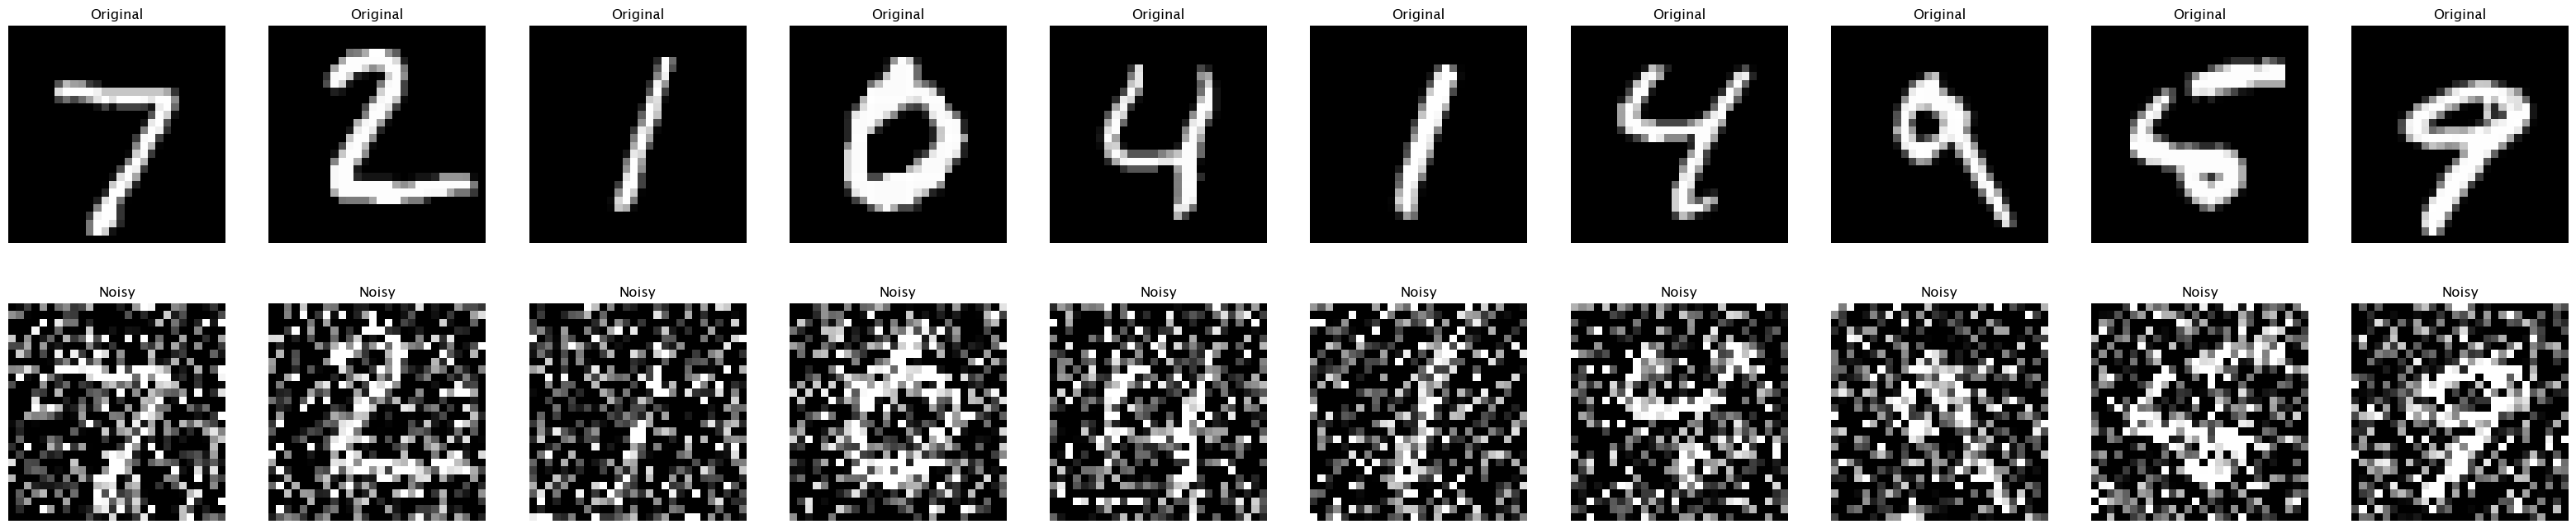

In [8]:
def plot_samples(originale_samples: list[np.ndarray], noisy_samples: Optional[list[np.ndarray]] = None, reconstructed_samples: Optional[list[np.ndarray]] = None, labels: Optional[list[np.ndarray]] = None) -> None:
    """
    Plot the samples in a grid.
    
    Parameters:
    - originale_samples (list[np.ndarray]): The original samples
    - noisy_samples (list[np.ndarray]): The noisy samples
    - reconstructed_samples (list[np.ndarray]): The reconstructed samples
    - labels (list[np.ndarray]): The labels of the samples
    """
        
    # Build a list of image types to plot along with their titles.
    plot_info = [('Original', originale_samples)]
    if noisy_samples is not None:
        plot_info.append(('Noisy', noisy_samples))
    if reconstructed_samples is not None:
        plot_info.append(('Reconstructed', reconstructed_samples))
        
    # Get the number of rows and samples.
    n_rows = len(plot_info)
    n_samples = len(originale_samples)
    
    # Create a grid: columns = samples, rows = image types.
    _, axes = plt.subplots(n_rows, n_samples, figsize=(n_samples * 4, n_rows * 4))
    
    # Ensure axes is a 2D array.
    if n_rows == 1:
        axes = np.expand_dims(axes, axis=0) 
    if n_samples == 1:
        axes = np.expand_dims(axes, axis=1)
    
    def add_image(ax: Any, image: np.ndarray, title: str) -> None:
        """
        Add an image to a subplot.
        
        Parameters:
        - ax (Any): The subplot to add the image to
        - image (np.ndarray): The image to add to the subplot
        - title (str): The title of the subplot
        """
        
        ax.imshow(image, cmap='gray')
        ax.axis('off')
        ax.set_title(title)
    
    # Loop over rows (image types) and columns (samples).
    for i, (title_prefix, samples) in enumerate(plot_info):
        for j in range(n_samples):
            # Append the label text if provided.
            add_image(axes[i, j], samples[j], title_prefix)
        
# Plot the first 10 samples
plot_samples(
    originale_samples = list(X_test[:10]),
    noisy_samples = list(X_test_noisy[:10]),
    labels = y_test[:10]
)

In [9]:
# Define the dimension of the latent space
latent_dim = 32

# Create the encoder
encoder = Model(
    name = 'Encoder',
    modules = [
        layers.Input(shape=X_train_noisy_flatten.shape[1:]),
        layers.Dense(num_units=128, activation=activations.ReLU()),
        layers.Dense(num_units=64, activation=activations.ReLU()),
        layers.Dense(num_units=latent_dim, activation=activations.ReLU(), name='Latent'),
    ]
)

# Create the decoder
decoder = Model(
    name = 'Decoder',
    modules = [
        layers.Input(shape=(latent_dim,), name='Latent'),
        layers.Dense(num_units=64, activation=activations.ReLU()),
        layers.Dense(num_units=128, activation=activations.ReLU()),
        layers.Dense(num_units=X_train_noisy_flatten.shape[1], activation=activations.Sigmoid())
    ]
)

# Create the auto-encoder
autoencoder = Model(
    name = 'Autoencoder',
    modules = [
        encoder,
        decoder
    ]
)

# Initialize the optimizer
optimizer = optimizers.Adam(learning_rate)

# Initialize the loss function
loss_fn = loss_functions.BinaryCrossEntropy()

In [10]:
# Call the model with a first batch to initialize the weights
# This is not necessary, but it is useful to know the input size
autoencoder(X_train_noisy_flatten[:batch_size]);

In [11]:
# Display the encoder summary
encoder.summary()

# Display the decoder summary
decoder.summary()

# Display the model summary
autoencoder.summary()


Encoder (ID: 0)

--------------------------------------------------------------------------------
Module (type)                           Output Shape        Trainable params #  
input_1 (Input)                         (512, 784)          0                   
--------------------------------------------------------------------------------
dense_2 (Dense)                         (512, 128)          100480              
--------------------------------------------------------------------------------
dense_3 (Dense)                         (512, 64)           8256                
--------------------------------------------------------------------------------
Latent (Dense)                          (512, 32)           2080                
Total trainable parameters: 110816
--------------------------------------------------------------------------------

Decoder (ID: 1)

--------------------------------------------------------------------------------
Module (type)                         

### Training the model

In [12]:
history = autoencoder.fit(
    X_train = X_train_noisy_flatten,
    y_train = X_train_flatten,
    optimizer = optimizer,
    loss_fn = loss_fn,
    X_valid = X_valid_noisy_flatten,
    y_valid = X_valid_flatten,
    batch_size = batch_size,
    epochs = epochs,
    callbacks = [callbacks.EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/200 --> loss: 0.5134  | Validation loss: 0.4046 
Epoch 2/200 --> loss: 0.4033  | Validation loss: 0.3972 
Epoch 3/200 --> loss: 0.3948  | Validation loss: 0.3899 
Epoch 4/200 --> loss: 0.3857  | Validation loss: 0.3735 
Epoch 5/200 --> loss: 0.3695  | Validation loss: 0.3627 
Epoch 6/200 --> loss: 0.3553  | Validation loss: 0.3412 
Epoch 7/200 --> loss: 0.3342  | Validation loss: 0.3244 
Epoch 8/200 --> loss: 0.3095  | Validation loss: 0.2952 
Epoch 9/200 --> loss: 0.2891  | Validation loss: 0.2836 
Epoch 10/200 --> loss: 0.2776  | Validation loss: 0.2725 
Epoch 11/200 --> loss: 0.2681  | Validation loss: 0.2658 
Epoch 12/200 --> loss: 0.2625  | Validation loss: 0.2623 
Epoch 13/200 --> loss: 0.2585  | Validation loss: 0.2585 
Epoch 14/200 --> loss: 0.2545  | Validation loss: 0.2553 
Epoch 15/200 --> loss: 0.2507  | Validation loss: 0.2512 
Epoch 16/200 --> loss: 0.2473  | Validation loss: 0.2489 
Epoch 17/200 --> loss: 0.2448  | Validation loss: 0.2456 
Epoch 18/200 --> loss: 

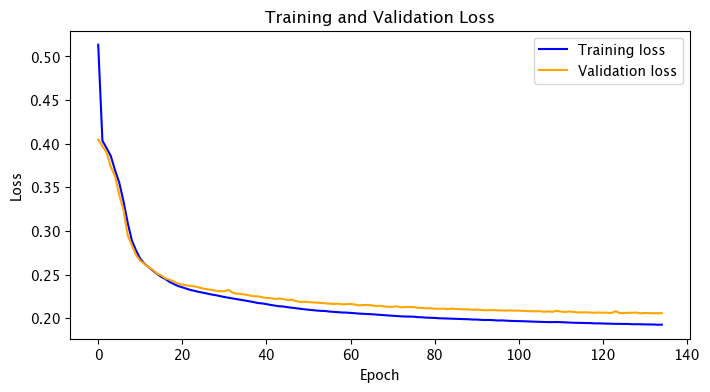

In [13]:
# Plot the training and validation loss
utils.plot_history(history["loss"], history["val_loss"], "Training and Validation Loss", "Epoch", "Loss")

### Inference

In [14]:
# Denoise the test set
X_test_denoised = autoencoder(
    x = X_test_noisy_flatten,
    batch_size = batch_size
)

# Reshape the denoised test set
X_test_denoised = X_test_denoised.reshape(-1, *X_test.shape[1:])

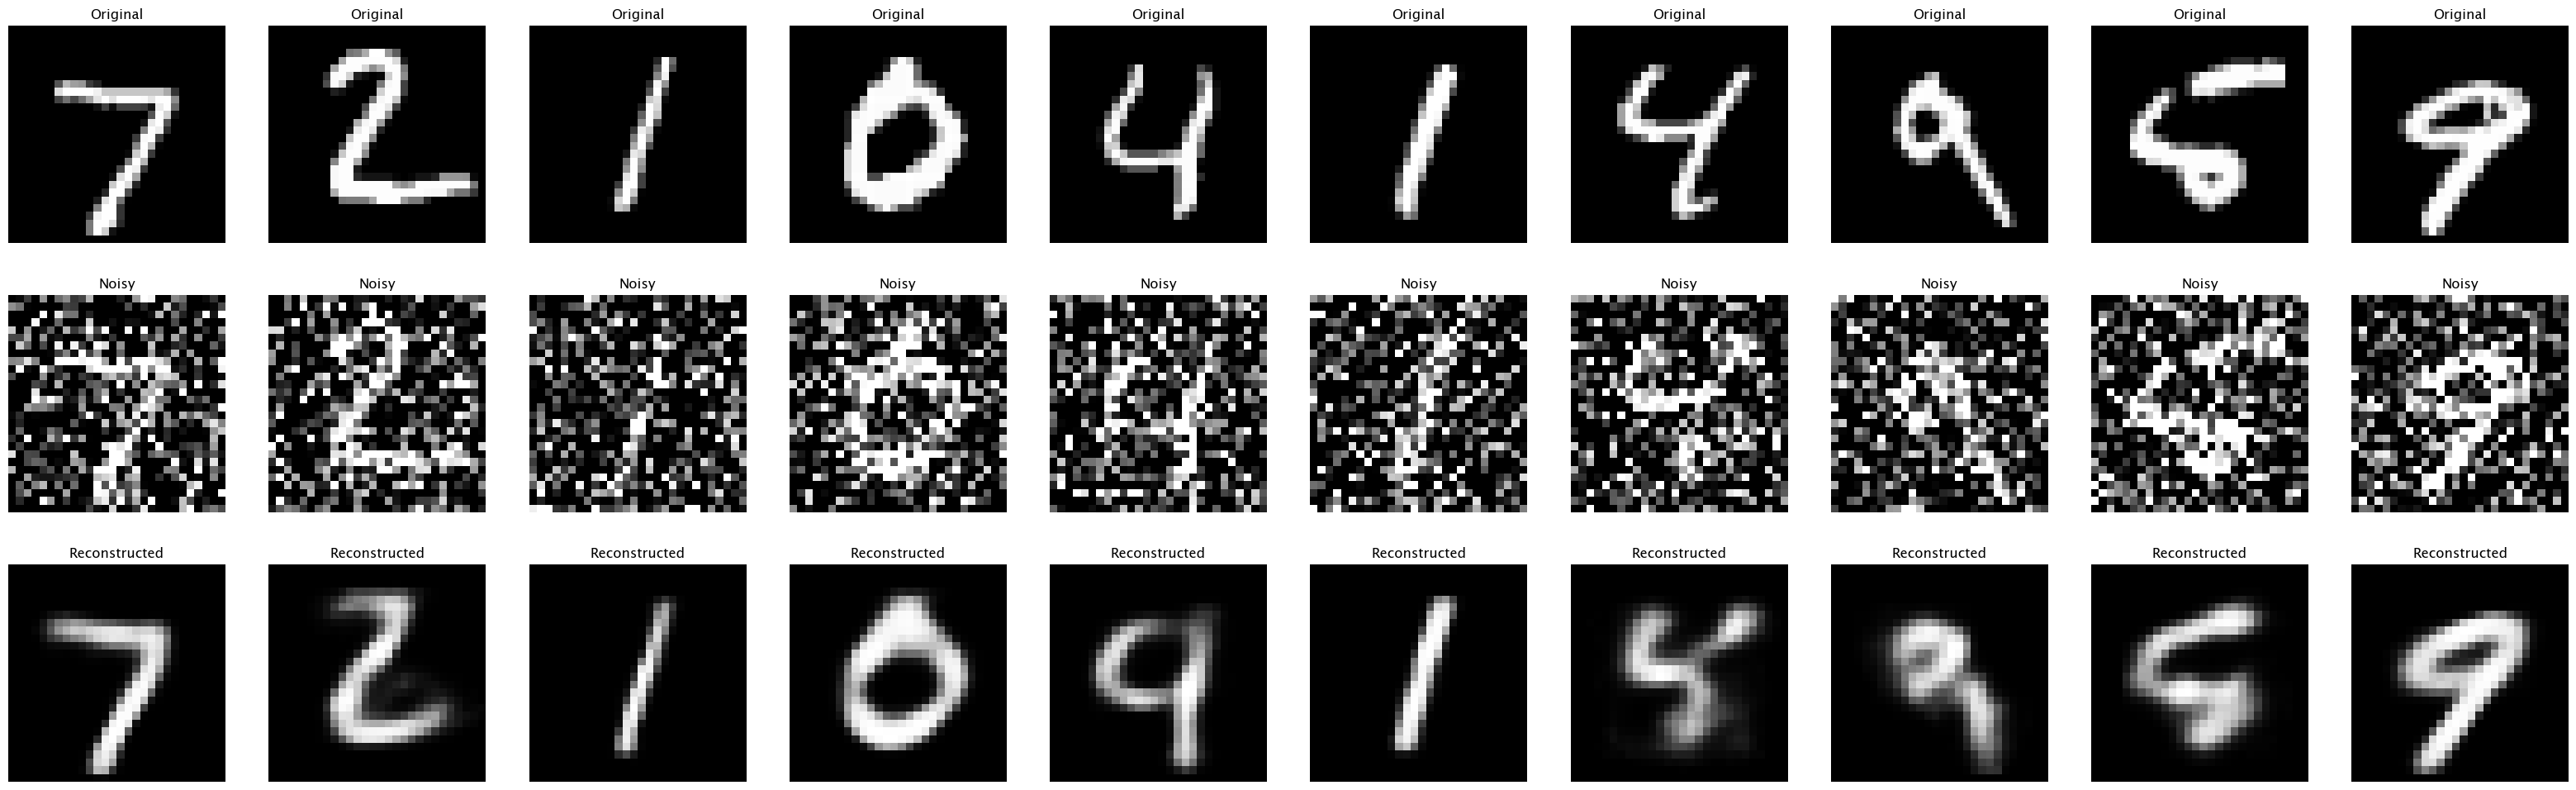

In [15]:
# Plot the first 10 samples
plot_samples(
    originale_samples = list(X_test[:10]),
    noisy_samples = list(X_test_noisy[:10]),
    reconstructed_samples = list(X_test_denoised[:10]),
    labels = y_test[:10]
)

### Generation

In [34]:
# Generate n random images (noise)
n_images = 10
random_images = np.random.rand(n_images, *X_train.shape[1:])
random_images = add_noise(random_images, noise_factor)

In [35]:
# Define the number of denoise steps
denoise_steps = 10

# Create a list to store the denoised images
denoised_images = [random_images.reshape(-1, *X_train.shape[1:])]

# Iterate over the denoise steps
for i in range(denoise_steps):
    # Denoise the random images using the autoencoder
    random_images = autoencoder(random_images.reshape(random_images.shape[0], -1))
    
    # Add the denoised images to the list
    denoised_images.append(random_images.reshape(-1, *X_train.shape[1:]))

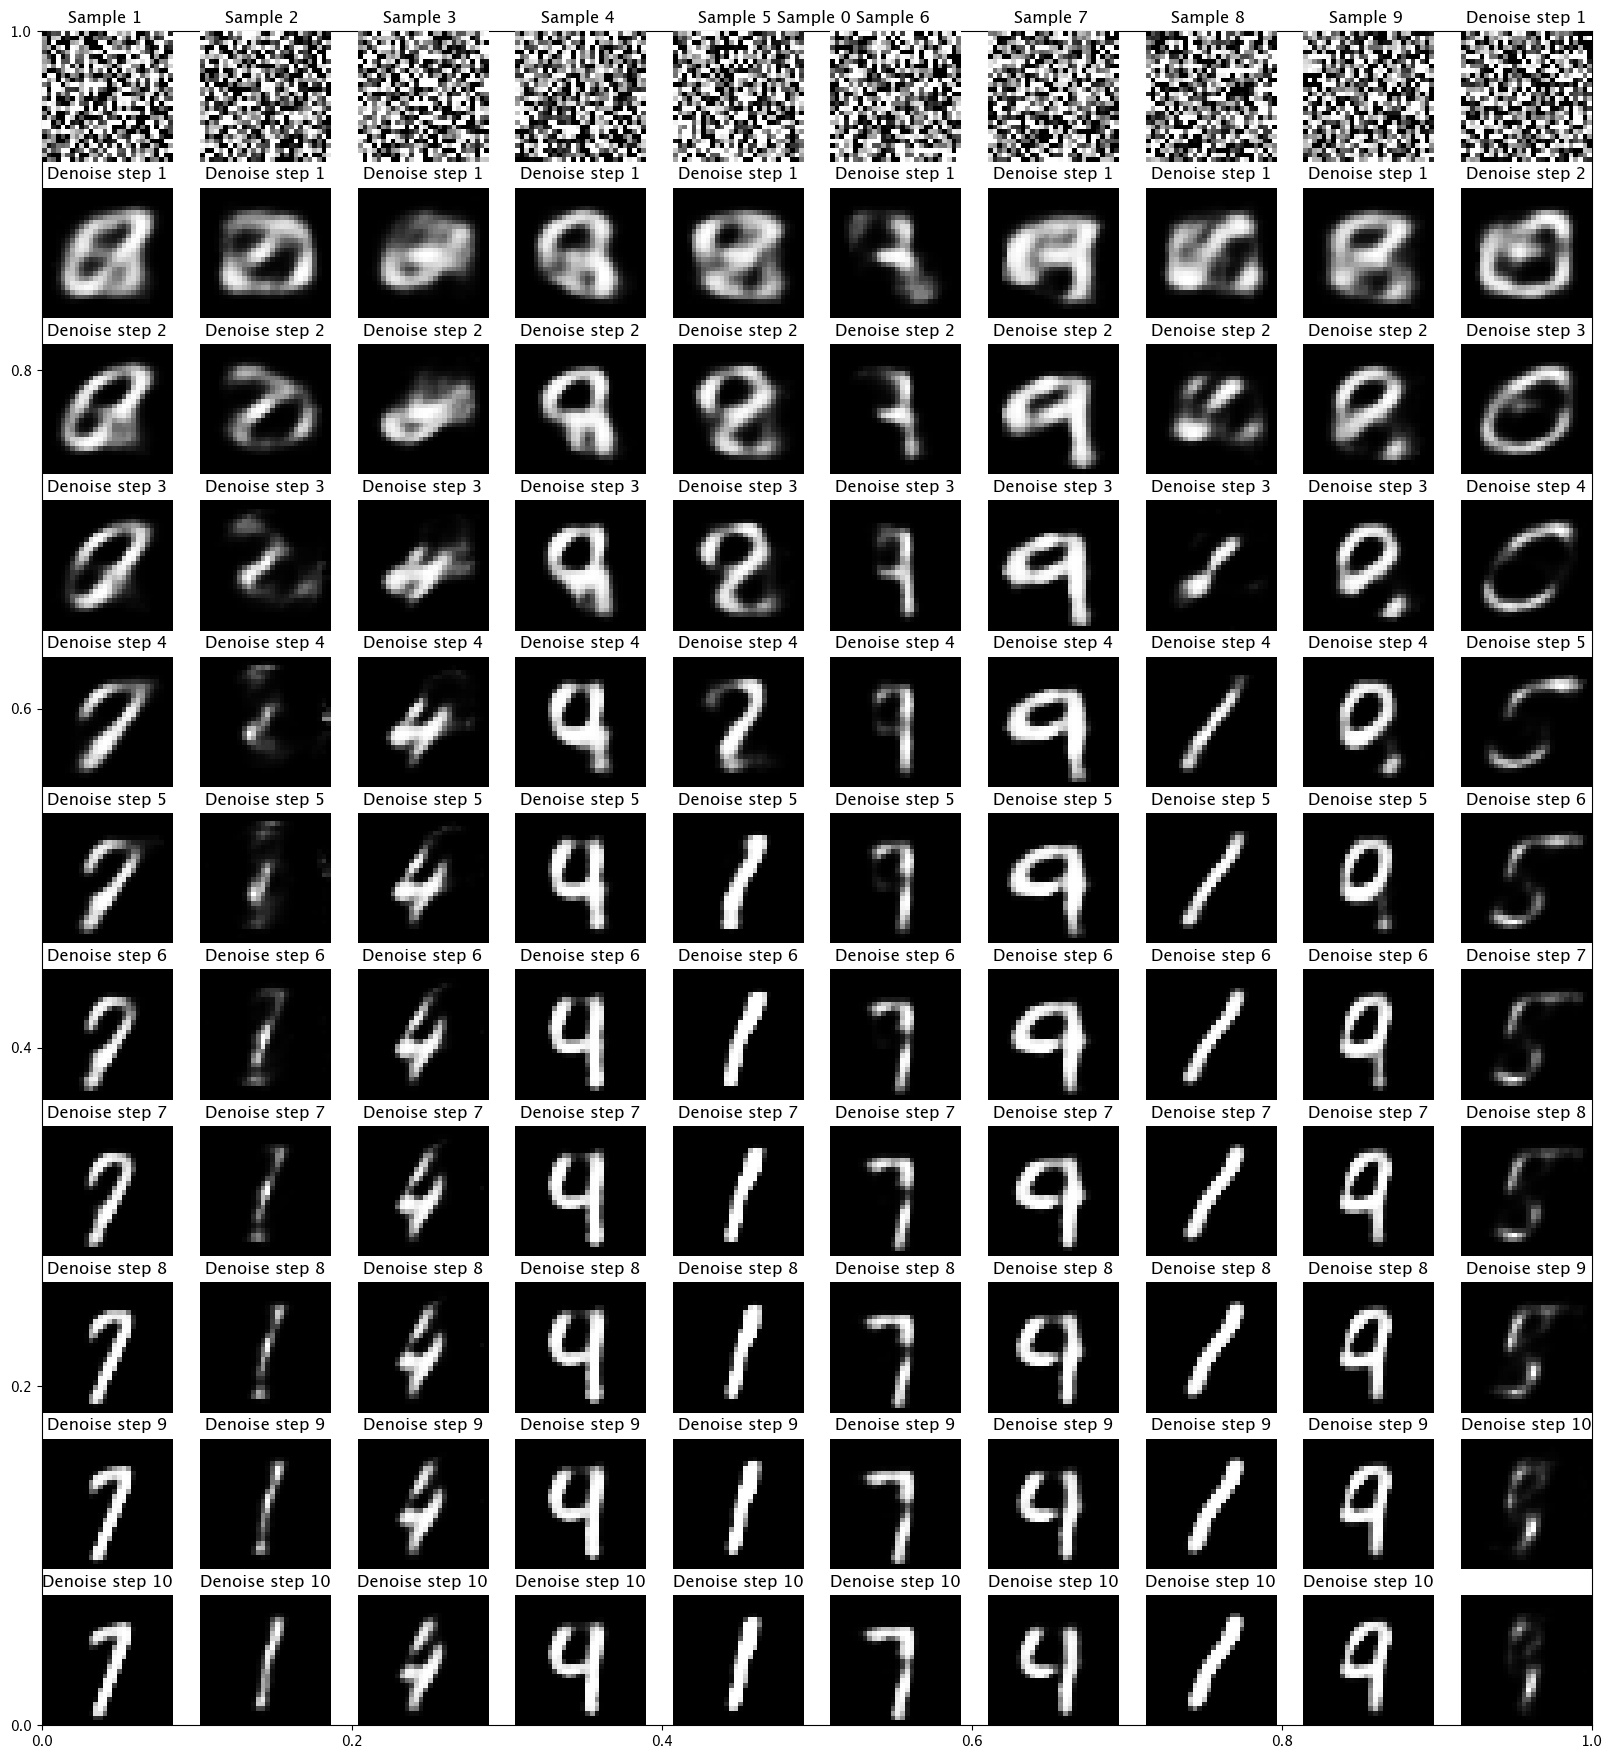

In [48]:
# Plot the denoised images
plt.figure(figsize=(2*n_images, 2*len(denoised_images)))
for i, images in enumerate(denoised_images):
    for j, image in enumerate(images):
        plt.title(f'Sample {j} ' if i == 0 else f'Denoise step {i}')
        plt.subplot(len(denoised_images), n_images, i * n_images + j + 1)
        plt.imshow(image, cmap='gray')
        plt.axis('off')